In [1]:
from pipnet.pipnet import PIPNet, get_network
from util.log import Log
import torch.nn as nn
from util.args import get_args, save_args, get_optimizer_nn
from util.data import get_dataloaders
from util.func import init_weights_xavier
from pipnet.train import train_pipnet, test_pipnet
# from pipnet.test import eval_pipnet, get_thresholds, eval_ood
from util.eval_cub_csv import eval_prototypes_cub_parts_csv, get_topk_cub, get_proto_patches_cub
import torch
from util.vis_pipnet import visualize, visualize_topk
from util.visualize_prediction import vis_pred, vis_pred_experiments
import sys, os
import random
import numpy as np
from shutil import copy
import matplotlib.pyplot as plt
from copy import deepcopy

from omegaconf import OmegaConf
from util.node import Node
import shutil
from util.phylo_utils import construct_phylo_tree, construct_discretized_phylo_tree
import pickle
from util.func import get_patch_size
import random
from util.data import ModifiedLabelLoader
from tqdm import tqdm

Heatmaps showing where a prototype is found will not be generated because OpenCV is not installed.


In [2]:
# run_path = '/home/harishbabu/projects/PIPNet/runs/010-CUB-27-imgnet_OOD_cnext26_img=224_nprotos=20'
# run_path = '/home/harishbabu/projects/PIPNet/runs/031-CUB-18-imgnet_cnext26_img=224_nprotos=20_orth-on-rel'
# run_path = '/home/harishbabu/projects/PIPNet/runs/032-CUB-18-imgnet_cnext26_img=224_nprotos=20_orth-on-rel'
# run_path = '/home/harishbabu/projects/PIPNet/runs/035-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel'
# run_path = '/home/harishbabu/projects/PIPNet/runs/043-035_clone-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel'
# run_path = "/home/harishbabu/projects/PIPNet/runs/036-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel_uniformity"
# run_path = "/home/harishbabu/projects/PIPNet/runs/041-035_clone-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel"
# run_path = "/home/harishbabu/projects/PIPNet/runs/042-035_clone-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel"
# run_path = "/home/harishbabu/projects/PIPNet/runs/044-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20-or-4per-desc_orth-on-rel"
# run_path = "/home/harishbabu/projects/PIPNet/runs/046-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=10per-desc_orth-on-rel"
# run_path = "/home/harishbabu/projects/PIPNet/runs/047-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=5per-desc_tanh-desc"
# run_path = "/home/harishbabu/projects/PIPNet/runs/048-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=5per-desc_tanh-desc_unit-sphere"
# run_path = "/home/harishbabu/projects/PIPNet/runs/051-CUB-18-imgnet_cnext26_img=224_nprotos=4per-desc_tanh-desc_unit-sphere_AW=5-TW=2-UW=2-CW=2"
# run_path = "/home/harishbabu/projects/PIPNet/runs/052-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=4per-desc_tanh-desc_unit-sphere_AW=5-TW=2-UW=2-CW=2"
# run_path = "/home/harishbabu/projects/PIPNet/runs/055-CUB-18_cnext26_img=224_nprotos=4per-desc_unit-sphere_no-softmax_AW=3-TW=2-UW=3-CW=2"
# run_path = "/home/harishbabu/projects/PIPNet/runs/056-CUB-18-imgnet_cnext26_img=224_nprotos=4per-desc_unit-sphere_no-softmax_AW=3-TW=2-UW=3-CW=2"
# run_path = "/home/harishbabu/projects/PIPNet/runs/057-CUB-18-imgnet_cnext26_img=224_nprotos=4per-desc_unit-sphere_no-meanpool_no-softmax_AW=3-TW=2-UW=3-CW=2"
# run_path = "/home/harishbabu/projects/PIPNet/runs/058-CUB-18-imgnet_with-equalize-aug_cnext26_img=224_nprotos=4per-desc_unit-sphere_no-meanpool_no-softmax_AW=3-TW=2-UW=3-CW=2"
run_path = "/home/harishbabu/projects/PIPNet/runs/059-CUB-18-imgnet_with-equalize-aug_cnext26_img=224_nprotos=4per-desc_unit-sphere_finetune=5_no-meanpool_no-softmax_AW=3-TW=2-UW=3-CW=2_batch=20"
args_file = open(os.path.join(run_path, 'metadata', 'args.pickle'), 'rb')
args = pickle.load(args_file)

if args.phylo_config:
    phylo_config = OmegaConf.load(args.phylo_config)

if args.phylo_config:
    # construct the phylo tree
    if phylo_config.phyloDistances_string == 'None':
        if '031' in run_path: # this run uses a different phylogeny file that had an extra root node which is a mistake
            root = construct_phylo_tree('/home/harishbabu/data/phlyogenyCUB/18Species-with-extra-root-node/1_tree-consensus-Hacket-18Species-modified_cub-names_v1.phy')
        else:
            root = construct_phylo_tree(phylo_config.phylogeny_path)
        print('-'*25 + ' No discretization ' + '-'*25)
    else:
        root = construct_discretized_phylo_tree(phylo_config.phylogeny_path, phylo_config.phyloDistances_string)
        print('-'*25 + ' Discretized ' + '-'*25)
else:
    # construct the tree (original hierarchy as described in the paper)
    root = Node("root")
    root.add_children(['animal','vehicle','everyday_object','weapon','scuba_diver'])
    root.add_children_to('animal',['non_primate','primate'])
    root.add_children_to('non_primate',['African_elephant','giant_panda','lion'])
    root.add_children_to('primate',['capuchin','gibbon','orangutan'])
    root.add_children_to('vehicle',['ambulance','pickup','sports_car'])
    root.add_children_to('everyday_object',['laptop','sandal','wine_bottle'])
    root.add_children_to('weapon',['assault_rifle','rifle'])
    # flat root
    # root.add_children(['scuba_diver','African_elephant','giant_panda','lion','capuchin','gibbon','orangutan','ambulance','pickup','sports_car','laptop','sandal','wine_bottle','assault_rifle','rifle'])
root.assign_all_descendents()

# if 'tanh-desc' in run_path:
for node in root.nodes_with_children():
    node.set_num_protos(args.num_protos_per_descendant)

------------------------- No discretization -------------------------


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    device_ids = [torch.cuda.current_device()]
else:
    device = torch.device('cpu')
    device_ids = []

args_file = open(os.path.join(run_path, 'metadata', 'args.pickle'), 'rb')
args = pickle.load(args_file)

# ckpt_file_name = 'net_overspecific_pruned_replaced_thresh=0.5_last'
ckpt_file_name = 'net_trained_last'
# ckpt_file_name = 'net_trained_10'
# ckpt_file_name = 'net_pretrained'
epoch = ckpt_file_name.split('_')[-1]

ckpt_path = os.path.join(run_path, 'checkpoints', ckpt_file_name)
checkpoint = torch.load(ckpt_path, map_location=device)

if ckpt_file_name != 'net_trained_last':
    print('\n', (10*'-')+'WARNING: Not using the final trained model'+(10*'-'), '\n')

# Obtain the dataset and dataloaders
trainloader, trainloader_pretraining, trainloader_normal, trainloader_normal_augment, projectloader, testloader, test_projectloader, classes = get_dataloaders(args, device)
if len(classes)<=20:
    if args.validation_size == 0.:
        print("Classes: ", testloader.dataset.class_to_idx, flush=True)
    else:
        print("Classes: ", str(classes), flush=True)

# Create a convolutional network based on arguments and add 1x1 conv layer
feature_net, add_on_layers, pool_layer, classification_layers, num_prototypes = get_network(len(classes), args, root=root)
   
# Create a PIP-Net
net = PIPNet(num_classes=len(classes),
                    num_prototypes=num_prototypes,
                    feature_net = feature_net,
                    args = args,
                    add_on_layers = add_on_layers,
                    pool_layer = pool_layer,
                    classification_layers = classification_layers,
                    num_parent_nodes = len(root.nodes_with_children()),
                    root = root
                    )
net = net.to(device=device)
net = nn.DataParallel(net, device_ids = device_ids)    
net.load_state_dict(checkpoint['model_state_dict'],strict=True)
net.eval()
criterion = nn.NLLLoss(reduction='mean').to(device)

# Forward one batch through the backbone to get the latent output size
# with torch.no_grad():
#     xs1, _, _ = next(iter(trainloader))
#     xs1 = xs1.to(device)
#     proto_features, _, _ = net(xs1)
#     wshape = proto_features['root'].shape[-1]
#     args.wshape = wshape #needed for calculating image patch size
#     print("Output shape: ", proto_features['root'].shape, flush=True)
    
args.wshape = 26

Dropping 0 samples from trainloader
Dropping 0 samples from trainloader_pretraining
Dropping 0 samples from trainloader_normal
Dropping 0 samples from trainloader_normal_augment
Num classes (k) =  18 ['cub_001_Black_footed_Albatross', 'cub_002_Laysan_Albatross', 'cub_003_Sooty_Albatross', 'cub_004_Groove_billed_Ani', 'cub_023_Brandt_Cormorant'] etc.
Classes:  {'cub_001_Black_footed_Albatross': 0, 'cub_002_Laysan_Albatross': 1, 'cub_003_Sooty_Albatross': 2, 'cub_004_Groove_billed_Ani': 3, 'cub_023_Brandt_Cormorant': 4, 'cub_024_Red_faced_Cormorant': 5, 'cub_025_Pelagic_Cormorant': 6, 'cub_031_Black_billed_Cuckoo': 7, 'cub_032_Mangrove_Cuckoo': 8, 'cub_033_Yellow_billed_Cuckoo': 9, 'cub_045_Northern_Fulmar': 10, 'cub_050_Eared_Grebe': 11, 'cub_051_Horned_Grebe': 12, 'cub_052_Pied_billed_Grebe': 13, 'cub_053_Western_Grebe': 14, 'cub_086_Pacific_Loon': 15, 'cub_100_Brown_Pelican': 16, 'cub_101_White_Pelican': 17}


/home/harishbabu/.conda/envs/hpnet1/lib/python3.8/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Number of prototypes:  20
----------Prototypes per descendant: 4----------
Assigned 24 protos to child 052+053 of node root
Assigned 104 protos to child 004+086 of node root
Assigned 4 protos to child cub_052_Pied_billed_Grebe of node 052+053
Assigned 16 protos to child 053+050 of node 052+053
Assigned 24 protos to child 004+032 of node 004+086
Assigned 72 protos to child 086+045 of node 004+086
Assigned 4 protos to child cub_053_Western_Grebe of node 053+050
Assigned 8 protos to child 050+051 of node 053+050
Assigned 4 protos to child cub_004_Groove_billed_Ani of node 004+032
Assigned 16 protos to child 032+033 of node 004+032
Assigned 4 protos to child cub_086_Pacific_Loon of node 086+045
Assigned 64 protos to child 045+101 of node 086+045
Assigned 4 protos to child cub_050_Eared_Grebe of node 050+051
Assigned 4 protos to child cub_051_Horned_Grebe of node 050+051
Assigned 4 protos to child cub_032_Mangrove_Cuckoo of node 032+033
Assigned 8 protos to child 033+031 of node 032+033
Ass

# Proto activations on leaf descendents - topk images after using unit-sphere & tanh-desc LIKE ProtoPNet

In [4]:
# Proto activations on leaf descendents - topk images

from util.data import ModifiedLabelLoader
from collections import defaultdict
import heapq
import pdb
from util.vis_pipnet import get_img_coordinates
import torchvision.transforms as transforms
from PIL import Image, ImageDraw as D
import torchvision

topk = 10
save_images = True

def get_heap():
    list_ = []
    heapq.heapify(list_)
    return list_

patchsize, skip = get_patch_size(args)

for node in root.nodes_with_children():
#     if node.name == 'root':
#         continue
    non_leaf_children_names = [child.name for child in node.children if not child.is_leaf()]
    if len(non_leaf_children_names) == 0: # if all the children are leaf nodes then skip this node
        continue

    name2label = projectloader.dataset.class_to_idx
    label2name = {label:name for name, label in name2label.items()}
    modifiedLabelLoader = ModifiedLabelLoader(projectloader, node)
    coarse_label2name = modifiedLabelLoader.modifiedlabel2name
    node_label_to_children = {label: name for name, label in node.children_to_labels.items()}
    
    imgs = modifiedLabelLoader.filtered_imgs

#     img_iter = tqdm(enumerate(modifiedLabelLoader),
#                     total=len(modifiedLabelLoader),
#                     mininterval=50.,
#                     desc='Collecting topk',
#                     ncols=0)
    
    # maps class names to the prototypes that belong to that
    class_and_prototypes = defaultdict(set)
    
    # maps class names to the prototypes that DON'T have strong connection to classification
    class_and_non_relevant_prototypes = defaultdict(set)
    
    # maps child_class_name -> proto_number -> grand_child_name (or descendant leaf name) -> list of top-k activations
    proto_mean_activations = defaultdict(lambda: defaultdict(lambda: defaultdict(get_heap)))
    
    for child_node in node.children:
        classification_weights = getattr(net.module, '_'+node.name+'_'+child_node.name+'_classification').weight
        
#         if all([grand_child.is_leaf() for grand_child in child_node]):
#             continue

        img_iter = tqdm(enumerate(modifiedLabelLoader),
                    total=len(modifiedLabelLoader),
                    mininterval=50.,
                    desc='Collecting topk',
                    ncols=0)
        
        for i, (xs, orig_y, ys) in img_iter:
            
            if coarse_label2name[ys.item()] not in non_leaf_children_names:
                continue
                
            xs, ys = xs.to(device), ys.to(device)
            
            if coarse_label2name[ys.item()] != child_node.name:
                continue
            
            with torch.no_grad():
                # pooled is dict of dict, mapping [node.name][child_node.name] to correspoding pooled tensor
                # softmaxes is dict, mapping [node.name] to tensor that is produced after concatenating the output
                # of add_ons of each child node and doing softmax on them
                _, softmaxes, pooled, _ = net(xs, inference=False)
                pooled = pooled[node.name][child_node.name].squeeze(0)
                softmaxes = softmaxes[node.name]#.squeeze(0)
                softmaxes_split = torch.split(softmaxes, [node.num_protos_per_child[child_node.name] for child_node in node.children], dim=1)
                idx = [temp_child_node.name for temp_child_node in node.children].index(child_node.name)
                softmaxes_of_child_node = softmaxes_split[idx]
                
                for p in range(pooled.shape[0]): # pooled.shape -> [768] (== num of prototypes)
                    c_weight = torch.max(classification_weights[:,p]) # classification_weights[:,p].shape -> [200] (== num of classes)
#                     relevant_proto_class_names = child_node.descendents # names of all descendants of the child_node
                    if c_weight < 1e-3:
                        class_and_non_relevant_prototypes[child_node.name].add(p)
                        continue
                    relevant_proto_class_names = [child_node.name]
                    
                    # Take the max per prototype.                             
                    max_per_prototype, max_idx_per_prototype = torch.max(softmaxes_of_child_node, dim=0)
                    max_per_prototype_h, max_idx_per_prototype_h = torch.max(max_per_prototype, dim=1)
                    max_per_prototype_w, max_idx_per_prototype_w = torch.max(max_per_prototype_h, dim=1) #shape (num_prototypes)
                    
                    h_idx = max_idx_per_prototype_h[p, max_idx_per_prototype_w[p]]
                    w_idx = max_idx_per_prototype_w[p]

                    # if prototype not relevant # never happens
                    if len(relevant_proto_class_names) == 0:
                        continue
                        
                    # might happen but can be better written
                    if (len(relevant_proto_class_names) == 1) and (relevant_proto_class_names[0] not in non_leaf_children_names):
                        continue
                        
#                     h_coor_min, h_coor_max, w_coor_min, w_coor_max = get_img_coordinates(args.image_size, softmaxes_of_child_node.shape, patchsize, skip, h_idx, w_idx)
                    latent_activation = softmaxes_of_child_node[:, p, :, :]
                    raise
                    h_coor_min, h_coor_max, w_coor_min, w_coor_max = get_coords_using_activation_crop(softmaxes_of_child_node[:, p, :, :], xs.shape[-1])
                    
                    if (coarse_label2name[ys.item()] in relevant_proto_class_names):
#                         child_node = root.get_node(coarse_label2name[ys.item()])
                        leaf_descendent = label2name[orig_y.item()][4:7]
                        img_to_open = imgs[i][0] # it is a tuple of (path to image, lable)
                        if topk and (len(proto_mean_activations[child_node.name][p][leaf_descendent]) > topk):
                            heapq.heappushpop(proto_mean_activations[child_node.name][p][leaf_descendent], (pooled[p].item(), img_to_open, (h_coor_min, h_coor_max, w_coor_min, w_coor_max)))
                        else:
                            heapq.heappush(proto_mean_activations[child_node.name][p][leaf_descendent], (pooled[p].item(), img_to_open, (h_coor_min, h_coor_max, w_coor_min, w_coor_max)))
#                     pdb.set_trace()
                    class_and_prototypes[child_node.name].add(p)
    
    for child_classname in class_and_prototypes:
        print('-'*20, child_classname, class_and_prototypes[child_classname], '-'*20)
    for child_classname in class_and_non_relevant_prototypes:
        print('-'*20, child_classname, class_and_non_relevant_prototypes[child_classname], '-'*20)
    
    print('Node', node.name)
    for child_classname in class_and_prototypes:
        
        print('\t'*1, 'Child:', child_classname)
        for p in class_and_prototypes[child_classname]:
            
            logstr = '\t'*2 + f'Proto:{p} '
            for leaf_descendent in proto_mean_activations[child_classname][p]:
                mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[child_classname][p][leaf_descendent]]), 4)
                num_images = len(proto_mean_activations[child_classname][p][leaf_descendent])
                logstr += f'{leaf_descendent}:({mean_activation}) '
            print(logstr)
            
            if save_images:
                patches = []
                right_descriptions = []
                text_region_width = 7 # 7x the width of a patch
                for leaf_descendent, heap in proto_mean_activations[child_classname][p].items():
                    heap = sorted(heap)[::-1]
                    mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[child_classname][p][leaf_descendent]]), 4)
                    for ele in heap:
                        activation, img_to_open, (h_coor_min, h_coor_max, w_coor_min, w_coor_max) = ele
                        image = transforms.Resize(size=(args.image_size, args.image_size))(Image.open(img_to_open))
                        img_tensor = transforms.ToTensor()(image)#.unsqueeze_(0) #shape (1, 3, h, w)
                        img_tensor_patch = img_tensor[:, h_coor_min:h_coor_max, w_coor_min:w_coor_max]
                        patches.append(img_tensor_patch)

                    # description on the right hand side
                    text = f'{mean_activation}, {leaf_descendent}'
                    txtimage = Image.new("RGB", (patches[0].shape[-2]*text_region_width,patches[0].shape[-1]), (0, 0, 0))
                    draw = D.Draw(txtimage)
                    draw.text((5, patches[0].shape[1]//2), text, anchor='mm', fill="white")
                    txttensor = transforms.ToTensor()(txtimage)#.unsqueeze_(0)
                    right_descriptions.append(txttensor)

                grid = torchvision.utils.make_grid(patches, nrow=topk+1, padding=1)
                grid_right_descriptions = torchvision.utils.make_grid(right_descriptions, nrow=1, padding=1)

                # merging right description with the grid of images
#                 pdb.set_trace()
                grid = torch.cat([grid, grid_right_descriptions], dim=-1)

                # description on the top
                text = f'Node:{node.name}, p{p}, Child:{child_classname}'
                txtimage = Image.new("RGB", (grid.shape[-1], args.wshape), (0, 0, 0))
                draw = D.Draw(txtimage)
                draw.text((5, patches[0].shape[1]//2), text, anchor='mm', fill="white")
                txttensor = transforms.ToTensor()(txtimage)#.unsqueeze_(0)

                # merging top description with the grid of images
                grid = torch.cat([grid, txttensor], dim=1)

                os.makedirs(os.path.join(run_path, f'descendent_specific_topk_ep={epoch}', node.name), exist_ok=True)
                torchvision.utils.save_image(grid, os.path.join(run_path, f'descendent_specific_topk_ep={epoch}', node.name, f'{child_classname}-p{p}.png'))
            
print('Done !!!')

RuntimeError: No active exception to reraise

In [5]:
import os
import torch
import numpy as np
from PIL import Image
import pdb

def find_high_activation_crop(activation_map, percentile=99.9):
    threshold = np.percentile(activation_map, percentile)
    mask = np.ones(activation_map.shape)
    mask[activation_map < threshold] = 0
    lower_y, upper_y, lower_x, upper_x = 0, 0, 0, 0
    for i in range(mask.shape[0]):
        if np.amax(mask[i]) > 0.5:
            lower_y = i
            break
    for i in reversed(range(mask.shape[0])):
        if np.amax(mask[i]) > 0.5:
            upper_y = i
            break
    for j in range(mask.shape[1]):
        if np.amax(mask[:,j]) > 0.5:
            lower_x = j
            break
    for j in reversed(range(mask.shape[1])):
        if np.amax(mask[:,j]) > 0.5:
            upper_x = j
            break
    return (lower_y, upper_y+1, lower_x, upper_x+1), mask

def get_upsampled_activation(latent_activation, original_img_size):
    upsampled_act_img_j = torchvision.transforms.ToPILImage()(latent_activation).resize((original_img_size, original_img_size)) #, Image.BICUBIC)
    return np.array(upsampled_act_img_j)

def get_coords_using_activation_crop(latent_activation, original_img_size):
    pdb.set_trace()
    upsampled_act_img_j = get_upsampled_activation(latent_activation, original_img_size)
#     upsampled_act_img_j = cv2.resize(latent_activation, dsize=(original_img_size, original_img_size),
#                                              interpolation=cv2.INTER_CUBIC)
    proto_bound_j, _ = find_high_activation_crop(upsampled_act_img_j)
    h_coor_min, h_coor_max, w_coor_min, w_coor_max = proto_bound_j
    return h_coor_min, h_coor_max, w_coor_min, w_coor_maxq

346
0.04201188590377569
tensor(0.1408, device='cuda:0')


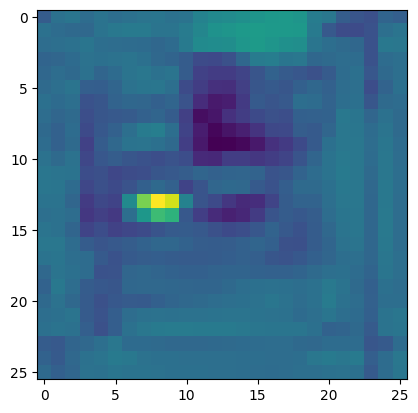

In [9]:
import matplotlib.pyplot as plt

plt.imshow(latent_activation.squeeze().cpu().numpy())

print(np.argmax(latent_activation.squeeze().cpu().numpy()))

print(np.percentile(latent_activation.squeeze().cpu().numpy(), 99)) #, method='inverted_cdf'))

print(latent_activation.max())


In [12]:
from PIL import Image
import numpy as np

# Assuming you have image A and image B loaded or generated as NumPy arrays

image_a = latent_activation.cpu().numpy()

print(image_a.shape)

input_image = (xs - xs.min()) / (xs.max() - xs.min())
image_b = input_image.squeeze().permute(1, 2, 0).cpu().numpy()

# Reshape image A to match the dimensions of image B (3x224x224)
reshaped_image_a = np.array(Image.fromarray(image_a.transpose(1, 2, 0)).resize((224, 224))).transpose(2, 0, 1)

# Convert NumPy arrays back to Pillow images
image_a_pillow = Image.fromarray(reshaped_image_a.transpose(1, 2, 0).astype('uint8'))
image_b_pillow = Image.fromarray(image_b.transpose(1, 2, 0).astype('uint8'))

# Overlay image A on top of image B with transparency
result_image = Image.blend(image_b_pillow, image_a_pillow, alpha=0.5)

# Display the new image
result_image.show()


(1, 26, 26)


TypeError: Cannot handle this data type: (1, 1, 1), <f4

(1, 26, 26)
(224, 224, 3)
(3, 224, 224)


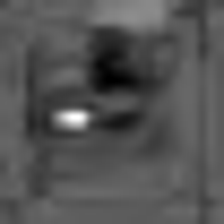

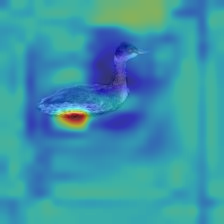

In [42]:
from PIL import Image
import numpy as np
import pdb

# Assuming you have image A and image B loaded or generated as NumPy arrays

image_a = latent_activation.cpu().numpy()
image_a = (image_a - image_a.min()) / (image_a.max() - image_a.min())

print(image_a.shape)

input_image = (xs - xs.min()) / (xs.max() - xs.min())
image_b = input_image.squeeze().permute(1, 2, 0).cpu().numpy()

print(image_b.shape)
print(image_b.transpose(2, 0, 1).shape)

# Reshape image A to match the dimensions of image B (3x224x224)
reshaped_image_a = np.array(Image.fromarray((image_a[0] * 255).astype('uint8')).resize((224, 224)))

# ----------------------------NEW

# Normalize the heatmap values to the range [0, 1]
normalized_heatmap = (reshaped_image_a - np.min(reshaped_image_a)) / (np.max(reshaped_image_a) - np.min(reshaped_image_a))

# pdb.set_trace()
# threshold = np.percentile(normalized_heatmap, 99.5)
# normalized_heatmap[normalized_heatmap < threshold] = 0

# Apply a color map to the heatmap (e.g., 'hot' colormap)
heatmap_colormap = plt.get_cmap('jet')
heatmap_colored = heatmap_colormap(normalized_heatmap)

# Convert the heatmap to uint8 format
heatmap_colored_uint8 = (heatmap_colored[:, :, :3] * 255).astype(np.uint8)



# Convert NumPy arrays back to Pillow images
image_a_heatmap_pillow = Image.fromarray(heatmap_colored_uint8)

# ----------------------------NEW

Image.fromarray((image_a[0] * 255).astype('uint8')).resize((224, 224)).show()

# ----------------------------OLD

# # Create a blank 3-channel (R, G, B) image of the same size
# reshaped_image_a_rgb = np.zeros((224, 224, 3), dtype=np.uint8)

# # Copy the single-channel image to all three channels
# reshaped_image_a_rgb[:, :, 0] = reshaped_image_a
# reshaped_image_a_rgb[:, :, 1] = reshaped_image_a
# reshaped_image_a_rgb[:, :, 2] = reshaped_image_a

# # Convert NumPy arrays back to Pillow images
# image_a_pillow = Image.fromarray((reshaped_image_a_rgb).astype('uint8'))

# ----------------------------OLD

image_b_pillow = Image.fromarray((image_b * 255).astype('uint8'))

# Overlay image A on top of image B with transparency
result_image = Image.blend(image_b_pillow, image_a_heatmap_pillow, alpha=0.5)

# Display the new image
result_image.show()


In [51]:
from PIL import Image
import numpy as np
import pdb

def get_heatmap(latent_activation, input_image):
    image_a = latent_activation.cpu().numpy()
    image_a = (image_a - image_a.min()) / (image_a.max() - image_a.min())

    input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
    image_b = input_image.permute(1, 2, 0).cpu().numpy()
    
    reshaped_image_a = np.array(Image.fromarray((image_a[0] * 255).astype('uint8')).resize((input_image.shape[-1], input_image.shape[-1])))
    normalized_heatmap = (reshaped_image_a - np.min(reshaped_image_a)) / (np.max(reshaped_image_a) - np.min(reshaped_image_a))
    
    heatmap_colormap = plt.get_cmap('jet')
    heatmap_colored = heatmap_colormap(normalized_heatmap)
    
    heatmap_colored_uint8 = (heatmap_colored[:, :, :3] * 255).astype(np.uint8)
    image_a_heatmap_pillow = Image.fromarray(heatmap_colored_uint8)
    pdb.set_trace()
    image_b_pillow = Image.fromarray((image_b * 255).astype('uint8'))

    result_image = Image.blend(image_b_pillow, image_a_heatmap_pillow, alpha=0.3)
    
    return np.array(result_image)


overlayed_image_np = get_heatmap(latent_activation, xs.squeeze())
Image.fromarray(overlayed_image_np).show()

> /tmp/ipykernel_31337/3431946088.py(21)get_heatmap()
     19     image_a_heatmap_pillow = Image.fromarray(heatmap_colored_uint8)
     20     pdb.set_trace()
---> 21     image_b_pillow = Image.fromarray((image_b * 255).astype('uint8'))
     22 
     23     result_image = Image.blend(image_b_pillow, image_a_heatmap_pillow, alpha=0.3)

ipdb> image_b.max()
1.0
ipdb> image_b.min()
0.0
ipdb> image_b/shape
*** NameError: name 'shape' is not defined
ipdb> image_b.shape
(224, 224, 3)
ipdb> q


In [49]:
print(xs.squeeze().shape)
print(latent_activation.shape)

print(xs.squeeze().min(), xs.squeeze().max())
print(latent_activation.min(), latent_activation.max())

torch.Size([3, 224, 224])
torch.Size([1, 26, 26])
tensor(-1.5455, device='cuda:0') tensor(2.2914, device='cuda:0')
tensor(-0.0745, device='cuda:0') tensor(0.1408, device='cuda:0')


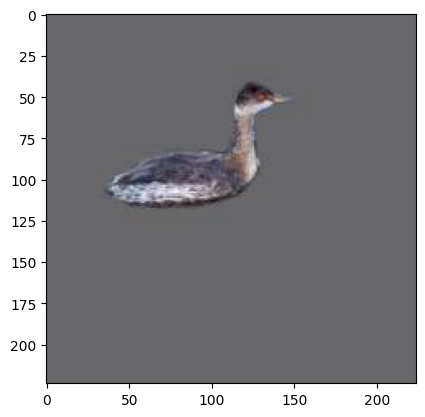

In [24]:

input_image = (xs - xs.min()) / (xs.max() - xs.min())
plt.imshow(input_image.squeeze().permute(1, 2, 0).cpu().numpy())

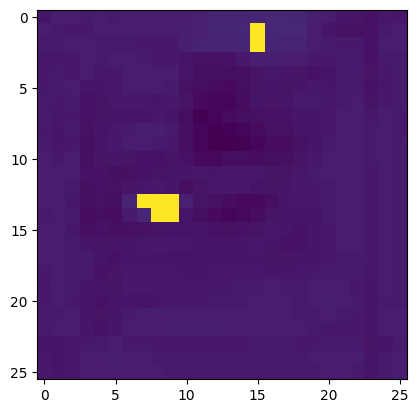

In [79]:
masked = latent_activation.squeeze().cpu().numpy()
threshold = np.percentile(latent_activation.squeeze().cpu().numpy(), 99)
masked[masked > threshold] = 1.0
plt.imshow(masked)

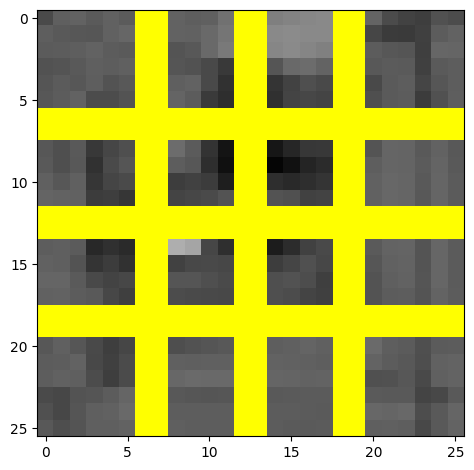

In [44]:
import skimage.segmentation as seg
import skimage.io as io

# Load your 26x26 single-channel image here (replace 'your_image.png' with your image file)
minmax_latent = (latent_activation - latent_activation.min()) / (latent_activation.max() - latent_activation.min())
image = minmax_latent.squeeze().cpu().numpy()

# Define the number of desired superpixels
num_superpixels = 16

# Perform superpixel segmentation using SLIC
labels = seg.slic(image, n_segments=num_superpixels)

# Create a segmented image based on the labels
segmented_image = seg.mark_boundaries(image, labels)

# Display the segmented image
io.imshow(segmented_image)
io.show()


[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [  0   0   0 ...   2   2   2]
 [  0   0   0 ...   2   2   2]
 [  0   0   0 ...   2   2   2]]


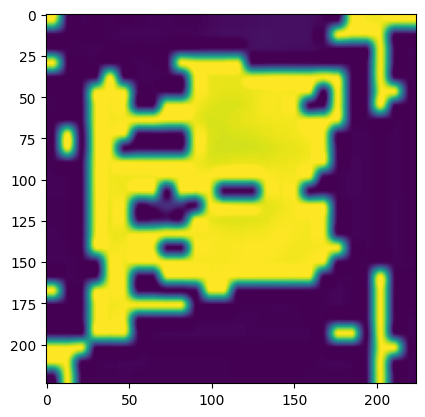

In [66]:
upsampled_act_img_j = get_upsampled_activation(latent_activation, 224)
print(upsampled_act_img_j)
plt.imshow(upsampled_act_img_j)

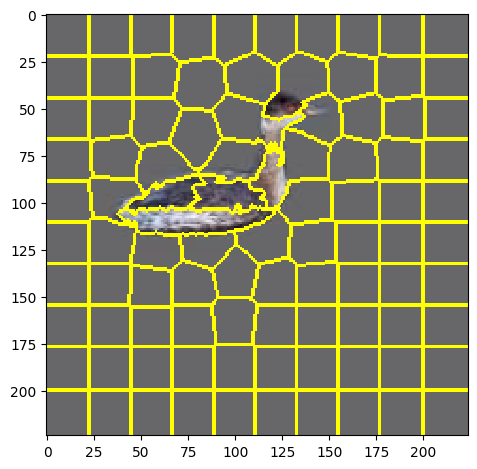

In [41]:
import skimage.segmentation as seg
import skimage.io as io

# Load your 26x26 single-channel image here (replace 'your_image.png' with your image file)
image = input_image.squeeze().permute(1, 2, 0).cpu().numpy()

# Define the number of desired superpixels
num_superpixels = 100

# Perform superpixel segmentation using SLIC
labels = seg.slic(image, n_segments=num_superpixels)

# Create a segmented image based on the labels
segmented_image = seg.mark_boundaries(image, labels)

# Display the segmented image
io.imshow(segmented_image)
io.show()


In [4]:
import cv2

ImportError: libX11.so.6: cannot open shared object file: No such file or directory

In [5]:
!pip show opencv-python

Name: opencv-python
Version: 4.7.0.72
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/opencv/opencv-python
Author: None
Author-email: None
License: Apache 2.0
Location: /home/harishbabu/.local/lib/python3.8/site-packages
Requires: numpy, numpy
Required-by: neorl


In [6]:
!pip uninstall opencv-python

Found existing installation: opencv-python 4.7.0.72
Uninstalling opencv-python-4.7.0.72:
  Would remove:
    /home/harishbabu/.local/lib/python3.8/site-packages/cv2/*
    /home/harishbabu/.local/lib/python3.8/site-packages/opencv_python-4.7.0.72.dist-info/*
    /home/harishbabu/.local/lib/python3.8/site-packages/opencv_python.libs/libQt5Core-39545cc7.so.5.15.0
    /home/harishbabu/.local/lib/python3.8/site-packages/opencv_python.libs/libQt5Gui-48e93776.so.5.15.0
    /home/harishbabu/.local/lib/python3.8/site-packages/opencv_python.libs/libQt5Test-c38a5234.so.5.15.0
    /home/harishbabu/.local/lib/python3.8/site-packages/opencv_python.libs/libQt5Widgets-e69d94fb.so.5.15.0
    /home/harishbabu/.local/lib/python3.8/site-packages/opencv_python.libs/libQt5XcbQpa-c112ba75.so.5.15.0
    /home/harishbabu/.local/lib/python3.8/site-packages/opencv_python.libs/libX11-xcb-69166bdf.so.1.0.0
    /home/harishbabu/.local/lib/python3.8/site-packages/opencv_python.libs/libXau-00ec42fe.so.6.0.0
    /home